FGSM (Fast Gradien Signed Method)

적대적 샘플 생성

신경망을 혼란시킬 목적으로 만들어진 특수 입력

In [1]:
# 미리 훈련되어 있는 모형 불러오기
import tensorflow as tf
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.summary()



14536120/14536120 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
              

In [2]:
pretrained_model.trainable = False  # 훈련된 모델 추론모드로 사용
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [3]:
# 이미지 전처리 함수
def preprocess(img):
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (224,224))
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    img = img[None, ...]
    return img

# 레이블 출력 함수
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]   # 확률값 높은 것 top=1 하나 뽑아내라

In [4]:
# sample image

image_raw = tf.io.read_file('Data/dog.jpg')
image = tf.image.decode_image(image_raw)
image

<tf.Tensor: shape=(577, 700, 3), dtype=uint8, numpy=
array([[[162, 167, 101],
        [157, 162,  96],
        [150, 156,  92],
        ...,
        [129, 137,  78],
        [123, 131,  71],
        [120, 128,  68]],

       [[158, 163,  97],
        [155, 160,  94],
        [152, 158,  94],
        ...,
        [132, 140,  81],
        [131, 139,  79],
        [130, 138,  78]],

       [[152, 159,  92],
        [153, 160,  93],
        [154, 160,  96],
        ...,
        [136, 144,  84],
        [139, 147,  87],
        [140, 148,  88]],

       ...,

       [[ 72,  63,  24],
        [ 76,  67,  28],
        [ 98,  90,  51],
        ...,
        [ 61,  70,   3],
        [ 83,  91,  16],
        [133, 140,  62]],

       [[134, 126,  89],
        [114, 106,  69],
        [150, 145, 107],
        ...,
        [ 72,  79,   9],
        [ 91,  97,  27],
        [140, 143,  74]],

       [[164, 164, 128],
        [186, 186, 150],
        [161, 163, 126],
        ...,
        [ 73,  78,   

In [5]:
image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 [==============================] - 13s 13s/step


In [13]:
image_probs.shape, image_probs

((1, 1000),
 array([[8.85021349e-04, 6.28015609e-04, 7.25382124e-05, 9.64735373e-05,
         4.41164768e-04, 3.66968452e-04, 6.85215637e-05, 1.86477599e-04,
         3.58788267e-04, 1.13704395e-04, 3.58338060e-04, 5.78532752e-04,
         3.52157018e-04, 5.33191487e-04, 1.84149845e-04, 1.37820549e-04,
         1.31517183e-04, 2.76528386e-04, 1.84453485e-04, 2.82052497e-04,
         1.69199222e-04, 1.36496034e-04, 3.06017086e-04, 9.59250028e-05,
         1.91388142e-04, 6.04510191e-04, 5.20506183e-05, 1.55967966e-04,
         3.35875025e-04, 2.73079961e-04, 3.19334678e-04, 4.51541418e-04,
         1.02226615e-04, 1.43173267e-04, 1.28487882e-04, 7.87713332e-04,
         1.44465957e-04, 1.10740031e-04, 2.15369277e-04, 2.57171254e-04,
         6.42015249e-04, 1.50511216e-04, 1.66814949e-04, 2.18009183e-04,
         1.84889097e-04, 1.94989916e-04, 6.34301978e-04, 4.16065915e-04,
         2.08287063e-04, 1.04575920e-04, 3.44008149e-04, 1.66542028e-04,
         1.83544689e-04, 4.74898989e-05

In [6]:
import numpy as np
print(np.argmax(image_probs))
print(get_imagenet_label(image_probs))

208
('n02099712', 'Labrador_retriever', 0.41818547)


0.41818547


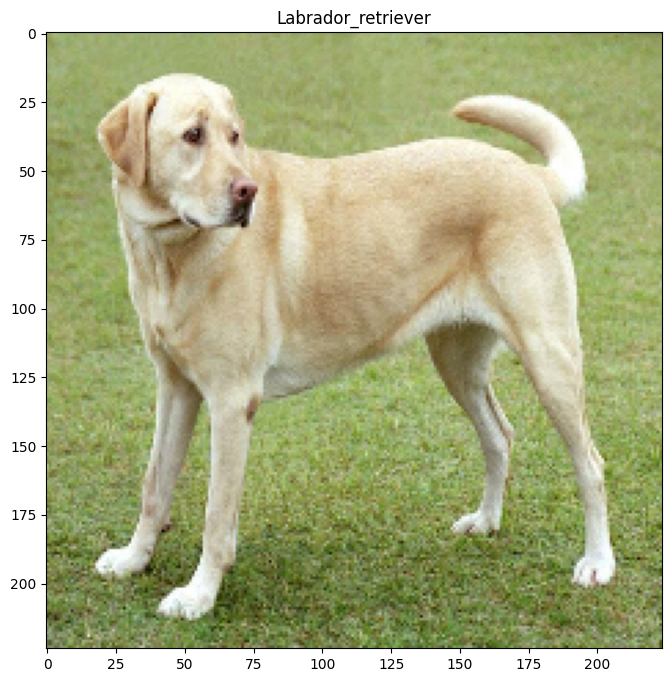

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['axes.grid'] = False

plt.figure()
plt.imshow(image[0]*0.5 + 0.5)   # to change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
print(class_confidence)
plt.title(f'{image_class}')
plt.show()

In [8]:
# 적대적 이미지 생성
# 입력이미지에 대한 gradient를 사용하여 원본이미지에 가하게 될 왜곡 생성

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adv_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

    # 원본과의 손실 계산
    gradient = tape.gradient(loss, input_image)

    signed_grad = tf.sign(gradient)
    return signed_grad

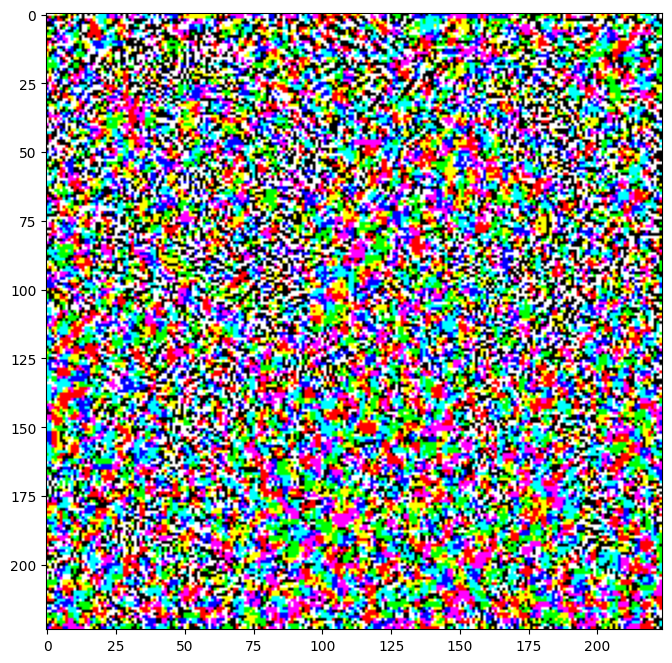

In [9]:
labrador_retriever_index = 208

# label 원핫인코딩
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))   

# 왜곡된 이미지 패턴 생성
perturbations = create_adv_pattern(image, label)
plt.imshow(perturbations[0]*0.5 + 0.5)  # to change [-1, 1] to [0, 1]


In [10]:
def display_img(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0]*0.5 + 0.5)
    plt.title(f'{description}\n {label}: {confidence*100:.2f}% Confidence')
    plt.show()


1/1 [==============================] - 0s 27ms/step


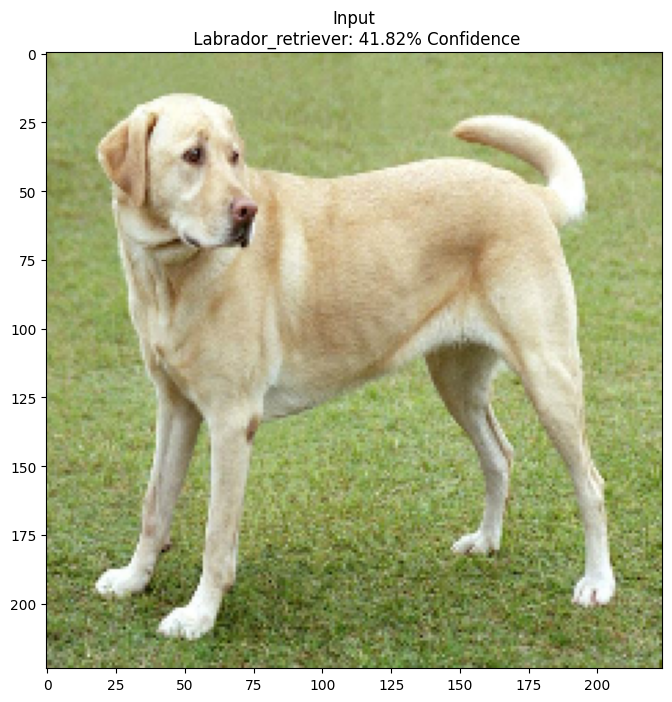

1/1 [==============================] - 0s 27ms/step


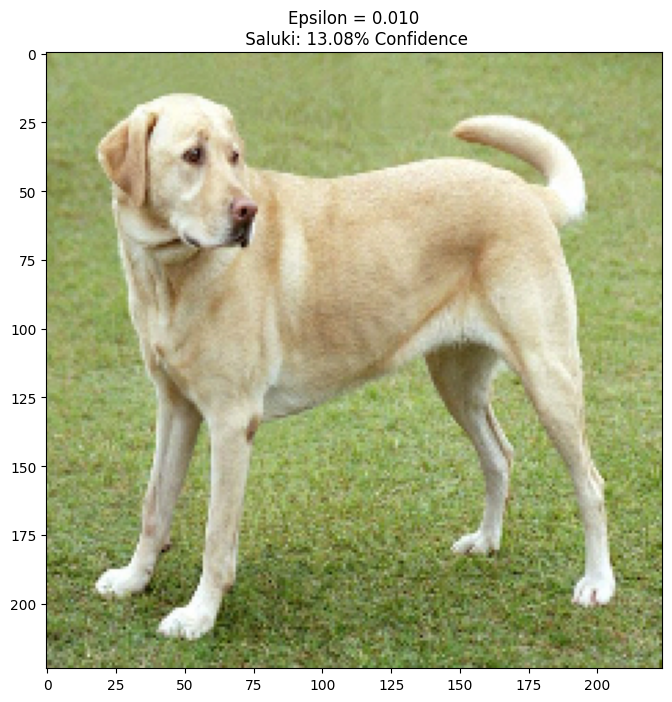

1/1 [==============================] - 0s 27ms/step


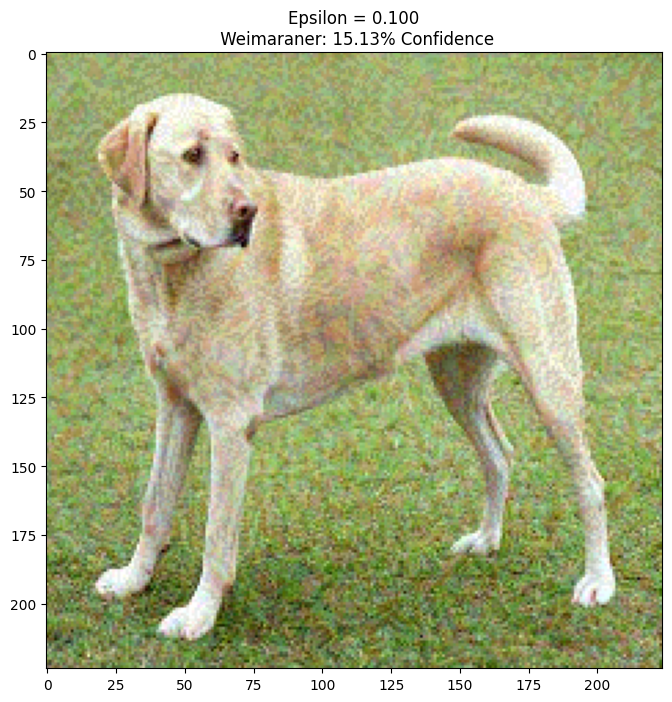

1/1 [==============================] - 0s 73ms/step


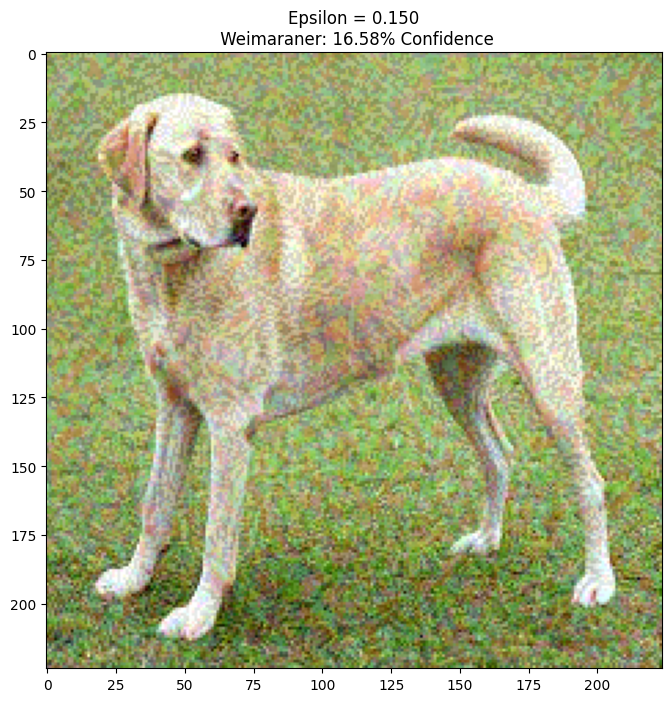

In [11]:
# 왜곡된 이미지로 인해 이미지 분류 오류 발생

epsilons = [0, 0.01, 0.1, 0.15]   # 값이 커질수록 왜곡이 심해짐
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)  #  픽셀값을 -1~1로 조절
    display_img(adv_x, descriptions[i])